## JobLib: A First Parallel Program

<div class="alert alert-success">
    This example is derived from Chapter 1 of Mattson, <i>Parallel Computing for Data Science</i>. The example in that chapter has been reimplemented in Python and the content and tone do not follow Mattson exactly.
</div>


    
### Mutual Outlinks -- A First Parallel Program
    
Big data analytics and graph processing grew out of the desire to understand the structure of Internet content and user behavior. The most famous example is the [Page Rank algorithm](https://en.wikipedia.org/wiki/PageRank), which changed the nature of Internet search and was crucial in the creation and early success of Google. We will look at PageRank in more detail later in the course.
    
For now, we are going to look at a simpler (but, typical and important) problem. The goal is to identify Web pages that link to the same content. Multiple Web pages that link to the same content may represent:
  * content clusters, i.e. similar pages
  * search engine gamification, i.e. unimportant pages that are trying to increase the ranking of target pages
    
 The input to this problem is a directed graph. Each Web page is a node in the graph and edges represent outlinks.

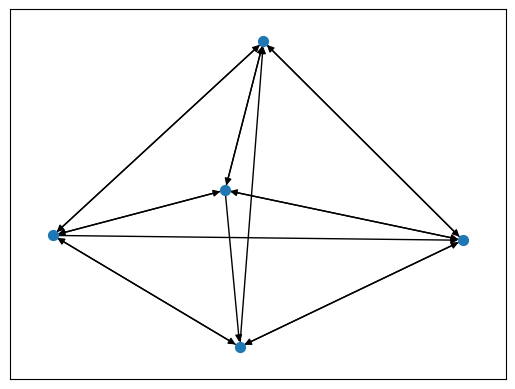

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

G = nx.erdos_renyi_graph(5,0.8, directed=True)
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_size=50)

In [21]:
gmat = nx.to_numpy_array(G)
gmat

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 1.],
       [0., 1., 1., 0., 1.],
       [1., 1., 0., 1., 0.]])

The natural algorithm uses a binary (0/1) matrix representation of the graph in which the rows and columns are node identifiers and nonzero entries indicate an outbound edge. The algorithm uses nested loops to iterate over all pairs of rows, computing a vector dot product that sums that number of mutual outlinks. 

In [23]:
gmat = nx.to_numpy_array(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[0]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]), np.asarray(gmat[j,:]))
outmat

array([[0., 3., 2., 3., 2.],
       [0., 0., 3., 2., 2.],
       [0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

Observe that the output matrix is an upper right triangular matrix. The lower left matrix if computed would be symmetric and redundant. We're trying to make code fast here. So, let's do no unneccessary work.

**Note**: We will not describe the individual operations in each example. The reader/student might use ChatGPT for code summaries to interpret the code line-by-line. This is a common practice and very effective, although ChatGPT is not always right.

### Aside: The Power of Python

Python has emerged as the language of choice for data science, Web development, and machine learning. The simplicity and concision of this program demonstrate why. Python is by no means the consensus __best__ language and many programming language experts have great disdain for Python's dynamic typing and syntax idiosyncracies (among other complaints). Much of what makes Python great is that Python is great! There is a huge network effect that has led to:
  * an incredible number of high-quality and well maintained packages
  * a huge user community that provides answers to every possible question you might have on Stack Overflow
  * ridiculously wonderful development tools
  * support on every platform that you can imagine
  
Here are reasons why I prefer Python to other languages. These are my opinions and not right:
  * Go: a better language that is useless because it has no reasonable debugging tools
  * R: a better language, but I cannot remember the syntax and am constantly looking stuff up
  * Perl/PHP: a worse language with even looser rules and more pitfalls than Python
  * JavaScript: too niche
  * and so on
  
Ironically, Python is **the worst** language for parallelism. There is a single choke point that prevents Python from running any two operations in parallel. This is called the `Global Interpreter Lock (GIL)`. We will look at this more deeply later. To realize parallelism in Python, we must work around this lock with a bunch of creative methods. 

#### Python Packages

Our example leverages three important data science packages:
  * numpy -- dense vector and matrix operations 
  * networkx -- graph and network analysis
  * matplotlib -- graph and visualization 
  
These package encapsulate complex functions so that you, the programmer, do not have to write them. Python packages encapsulate arbitrarily complex tasks in a single line of code. In this case:
  * generate an Erdos-Renyi random graph
  * display a planar representation of the graph
  * convert the graph to a binary matrix
  * compute the inner product of two vectors

### Back to the Example

Now let's generate a big graph and we'll start our performance analysis. Let's look at a serial version on a graph with 1000 nodes and about 5 outbound edges per node. 

10032

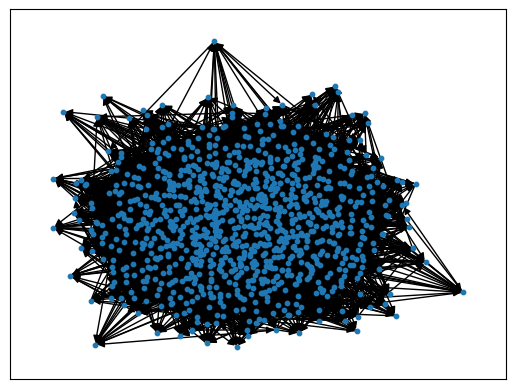

In [26]:
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_size=10)
G.number_of_edges()

For a graph this large, we cannot look at the matrix. We track the number of edges and mutual outlinks as a quick check to make sure that subsequent versions of the program produce the same output. 

In [27]:
import numpy as np

gmat = nx.to_numpy_array(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]), np.asarray(gmat[j,:]))
        
np.count_nonzero(outmat)

47716

Jupyter has nice `magics` that inject a bunch of code to realize some goal.  The `%timeit` magic runs an experiment to time the performance of a command and ``%%timeit`` runs the experiment on an entire Jupyter cell.

In [28]:
%%timeit

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

2.01 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is the serial performance. Let's parallelize the program and compare. We will use the _loop parellelism_ pattern (Mattson Chapter 4, more on this later.) Our first parallel program will decompose the matrix into chunks of rows and compute the partial result from each chunk. It then assembles the partial results into a matrix so that the parallel computation produces the same result as the serial.

`joblib` is a python package for parallelism. It inherits limitations from Python, but it is easy to use. This is the simplest program.

<img src="https://storage.googleapis.com/coderzcolumn/static/tutorials/python/article_image/joblib.jpg" width="512" title="joblib" /> 


In [29]:
def inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))    
    return partial_out
    
from joblib import Parallel, delayed
partials = Parallel(n_jobs=8)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
np.count_nonzero(outmat)

47716

OK, let's time it.

In [33]:
%%timeit

partials = Parallel(n_jobs=12)(delayed(inner_loop)(i) for i in range(gmat.shape[0]))

603 ms ± 4.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Great? That's faster, but not as fast as we would like. We are using mulitple processors, we would naively expect it to speed up in proportion to the number of processors. Alas, that's not the case. The next lecture on **Amdahl's Law** will explore some of the reasons why. Limitations in python account for the rest.

### `joblib` parallelism

What is `joblib` doing?
  * `delayed`: define a function call, delay its execution until later
  * create a generator that will enumerate all the delayed functions
  * `Parallel` create multiple independent "workers" that split the list of work to do into `n_jobs` parts and run the delayed functions in parallel.
  


## Poor Parallelism in Python and the GIL

I previoulsy told you that Python was the **worst** language for parallelism.  This is due to something called the **Global Interpreter Lock (GIL)**. The GIL makes it so that an instance of the Python runtime accepts only a single instruction at a time. Because of the GIL, running multiple threads in Python provides concurrency, but not parallelism.
  * *concurrent*: at the same time 
  * *parallel*: simultaneously
  
This is a subtle distinction. The best way to think about it is that `concurrency` means that multiple, asynchronous actions are defined. `parallelism` means that mutliple resources are computing at the same time.  Think of concurrency as a programming abstraction and parallelism as computing. 
  * Parallel programs must be concurrent. 
  * Concurrent programs are not necessarily run in parallel.
  
Let's do an example. Python `threads` are concurrent, but the GIL makes it so that Python only runs one instruction at a time. A simple program run serially and concurrently in threads will have about the same performance.

In [34]:
from random import random

def gen_random_01(count):
    for i in range(count):
        random()
        
gen_random_01(10)

In [35]:
%%timeit 

gen_random_01(10000000)

292 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
%%timeit 

from threading import Thread

for i in range(4):
  Thread(target=gen_random_01, args=(2500000,)).start()

295 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


To realize parallelism, one must use processes that create multiple seperate Python interpreters each with its own GIL.

In [38]:
%%timeit

from multiprocessing import Process

if __name__ == '__main__':
        
    for num in range(4):
        Process(target=gen_random_01, args=(2500000,)).start()

44.2 ms ± 5.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Although this realizes parallelism, creating mutliple Python instances has a bunch of overhead. We will dive into this later when we discuss threads and processes as operating systems abstractions. Parallel threads are more efficient than processes on a multicore computer. It's a shortcoming of Python that it cannot do parallelism in threads.

You will hear language about 'optimized packages that release the GIL'. The idea is that the functions release the lock during execution so that other threads can access the Python interpreter while the function is running. Packages that release the GIL realize parallelism in threads.  Each thread will:
  1. acquire the GIL
  2. execute a command in the Python interpreter
  3. release the GIL at the start of execution
  4. continue execution
  
This works sometimes. It requires careful programming by the package maintainer. Personally, I have found threads to be ineffective in Python. To realize parallelism, every function that you call inside a thread must release the GIL.